## Step 1. Load packages

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import cv2
from scipy.ndimage import rotate, zoom
from app import * 

2024-06-12 12:41:25.844317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Step 2. Pepare Visium

In [2]:
def otsu_filter(adata, tissue_dir):
    import cv2
    img = cv2.imread(tissue_dir + '/spatial/tissue_hires_image.png')

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

    ret, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    threshold_offset = 5  # This can be adjusted as needed
    new_thresh = ret + threshold_offset
    _, adjusted_otsu_thresh = cv2.threshold(blurred, new_thresh, 255, cv2.THRESH_BINARY)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(otsu_thresh, cmap='gray')
    plt.title('Original Otsu Thresholding')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(adjusted_otsu_thresh, cmap='gray')
    plt.title('Adjusted Otsu Thresholding')
    plt.axis('off')
    plt.show()

    br_coord = pd.read_csv(tissue_dir + '/spatial/tissue_positions_list.csv',
                        header=None, names= ['barcodes','tissue','row','col','imgrow','imgcol'])

    json_file_path = tissue_dir + '/spatial/scalefactors_json.json'
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    tissue_hires_scalef = data.get('tissue_hires_scalef')

    adata.obs['in_tissue'] = 1
    for i in range(adata.shape[0]):
        index = adata.obs.index[i]
        rr = br_coord[br_coord['barcodes'] == index]['imgrow'].values[0] * tissue_hires_scalef
        rr = int(rr)
        cc = br_coord[br_coord['barcodes'] == index]['imgcol'].values[0] * tissue_hires_scalef
        cc = int(cc)
    
        if adjusted_otsu_thresh[rr, cc] == 255:
            adata.obs['in_tissue'][i] = 0

    adata_ = adata[adata.obs['in_tissue'] == 1, ]
    return adata_

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


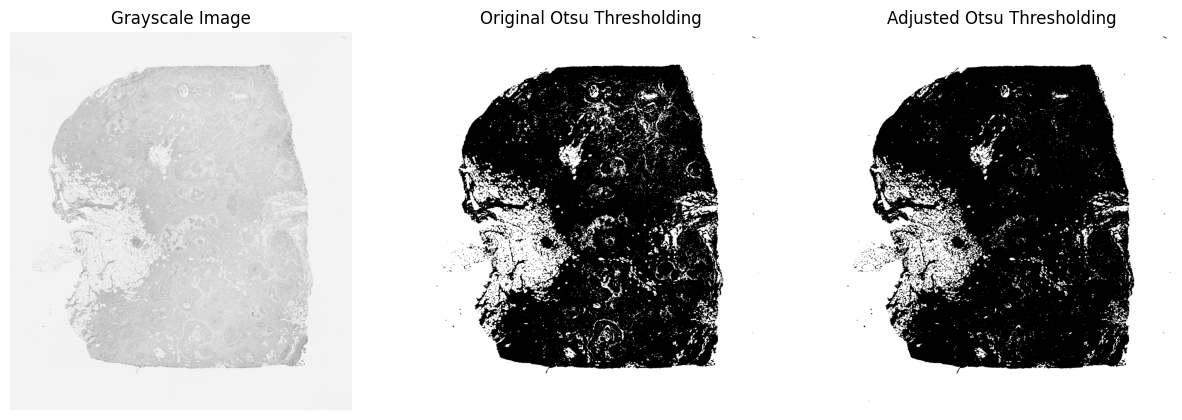

In [3]:
tissue_dir = './visium_xenium_human_breast_cancer/visium/'
visium = sc.read_visium(tissue_dir)
visium = otsu_filter(visium, tissue_dir)

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


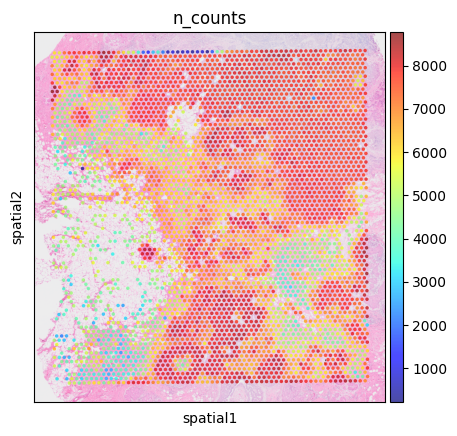

In [4]:
visium.var_names_make_unique() 
sc.pp.normalize_total(visium, inplace=True) 
sc.pp.log1p(visium)
visium.obs['n_counts'] = visium.X.sum(axis=1).A1
sc.pl.spatial(visium, img_key="hires", color='n_counts', alpha=0.7, cmap='jet')

## Step 3. Prepare Xenium

In [5]:
xenium = sc.read_h5ad('./240611_human_breast_xenium.h5ad')

## Step 4. SuperST

In [6]:
gene_list = xenium.var.index.intersection(visium.var.index)

In [7]:
iter = 400
demask_image_t, demask_image_t_g, tsimg1_, conv_spatial_images_ = \
         merge(tissue_dir, gene_list, num_iter = iter, is_cut_bg = True)

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


{'regist_target_img_scalef': 0.2781512, 'tissue_hires_scalef': 0.092717074, 'tissue_lowres_scalef': 0.027815122, 'fiducial_diameter_fullres': 191.75371240966362, 'spot_diameter_fullres': 127.8358082731091}


/home/jeongbinpark/_superst/_imagizer_mask.py:63: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  r, c = draw.circle(rr, cc, radius = radius)
2024-06-12 12:44:26.521090: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-12 12:44:26.523523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-12 12:44:26.556551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2024-06-12 12:44:26.556760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:98:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySi

number of features: 307
...1/307
...101/307
...201/307
...301/307
number of features: 307
...1/307
...101/307
...201/307
...301/307
number of features: 307
...1/307
...101/307
...201/307
...301/307


In [8]:
# Function to rotate, scale, and crop an image using margins
def process_image(img, angle, scale, left_margin, right_margin, top_margin, bottom_margin):
    # Rotate image
    rotated_img = rotate(img, angle, reshape=True, mode='nearest')
    
    # Determine the correct zoom tuple based on the number of dimensions in the rotated image
    if rotated_img.ndim == 2:  # Grayscale image
        zoom_factors = (scale, scale)  # Only scale x and y for grayscale
    else:  # RGB image
        zoom_factors = (scale, scale, 1)  # Scale x and y, keep color channels unchanged

    # Scale image
    scaled_img = zoom(rotated_img, zoom_factors, order=1)  # Apply zoom with corrected factors

    # Calculate crop coordinates based on margins
    start_row = top_margin
    end_row = scaled_img.shape[0] - bottom_margin
    start_col = left_margin
    end_col = scaled_img.shape[1] - right_margin

    # Crop image using calculated coordinates
    cropped_img = scaled_img[start_row:end_row, start_col:end_col]
    
    return cropped_img

# Function to convert an image to grayscale (only if it is in color)
def rgb_to_grayscale(img):
    # Check if image is already grayscale or RGB
    if img.ndim == 2:  # If the image is already grayscale
        return img
    else:  # If the image is RGB
        return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

In [9]:
def SuperST_to_xenium(xenium, tsimg1_, label="extracted_pixel_values", inverted=False):
    # Assuming tsimg1_ is loaded and is a numpy array
    # Define margins (hyperparameters)
    left_margin = 104
    right_margin = 86
    top_margin = 98
    bottom_margin = 163
    
    # Process the image: 90 degree CW rotation, scale by 2
    processed_img = process_image(tsimg1_, 90, 2, left_margin, right_margin, top_margin, bottom_margin)

    # Convert the processed image to grayscale
    grayscale_img = rgb_to_grayscale(processed_img)
    
    # Invert the grayscale colors by subtracting from the maximum
    if inverted:
        color_inverted_img = 255 - grayscale_img
    else:
        color_inverted_img = grayscale_img
        
    # 2. Normalize the 'x_centroid' and 'y_centroid' coordinates to the scale of the processed image
    x_norm = (xenium.obs['x_centroid'] - xenium.obs['x_centroid'].min()) / (xenium.obs['x_centroid'].max() - xenium.obs['x_centroid'].min())
    y_norm = (xenium.obs['y_centroid'] - xenium.obs['y_centroid'].min()) / (xenium.obs['y_centroid'].max() - xenium.obs['y_centroid'].min())
    
    # Convert normalized coordinates to image coordinates
    x_coords = np.round(x_norm * (color_inverted_img.shape[1] - 1)).astype(int)
    y_coords = np.round(y_norm * (color_inverted_img.shape[0] - 1)).astype(int)
    
    # 3. Access the pixel values from color inverted `grayscale_img` using these coordinates
    pixel_values = color_inverted_img[y_coords, x_coords]  # Get the pixel value (no channel index needed for grayscale)
    
    # Store these pixel values in xenium.obs under a new column
    xenium.obs[label] = pixel_values
    
    # Optionally, view a summary of the new data added to xenium.obs
    ##print(xenium.obs[['x_centroid', 'y_centroid', label]].head())

    return xenium

In [ ]:
for idx, gene in enumerate(gene_list):
    print(idx)
    xenium = SuperST_to_xenium(xenium, demask_image_t[idx], "SuperST_" + gene)
    gene_index = xenium.var.index.get_loc(gene)  # Get the integer index for the gene
    gene_expression = xenium.X[:, gene_index].toarray().flatten()  # Extract gene expression
    xenium.obs['GEX_' + gene] = gene_expression

In [ ]:
xenium.write_h5ad('240612_human_breast_xenium_SuperST_400.h5ad')

In [12]:
xenium = sc.read_h5ad('240612_human_breast_xenium_SuperST_400.h5ad')

/tmp/ipykernel_2223968/3479759578.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter.figure.colorbar(sm, label='Spearman Correlation')


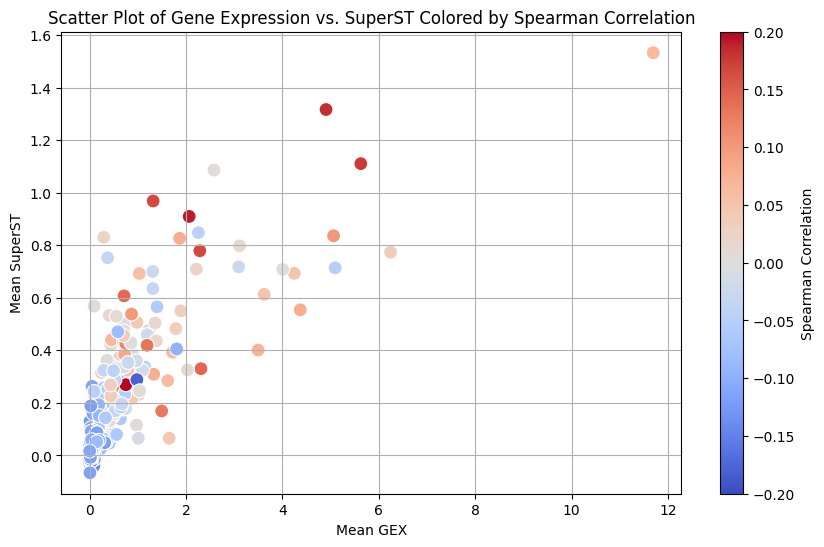

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Initialize a list to store plot data
plot_data = []

# Iterate over each gene to calculate correlation and prepare data for plotting
for gene in gene_list:
    # Access the gene expression and SuperST data
    gex_values = xenium.obs['GEX_' + gene]
    superst_values = xenium.obs['SuperST_' + gene]
    
    # Calculate the Spearman correlation coefficient
    correlation, _ = spearmanr(gex_values, superst_values)
    
    # Store data for this gene
    plot_data.append({
        'Gene': gene,
        'GEX': np.mean(gex_values),  # Using mean for plotting; adjust as needed
        'SuperST': np.mean(superst_values),  # Using mean for plotting; adjust as needed
        'Correlation': correlation
    })

# Convert list to DataFrame
df = pd.DataFrame(plot_data)

# Plotting
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='GEX', y='SuperST', hue='Correlation', palette='coolwarm', s=100, legend = None)

# Add a color bar
norm = plt.Normalize(vmin=-0.2, vmax=0.2)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
scatter.figure.colorbar(sm, label='Spearman Correlation')

plt.title('Scatter Plot of Gene Expression vs. SuperST Colored by Spearman Correlation')
plt.xlabel('Mean GEX')
plt.ylabel('Mean SuperST')
plt.grid(True)
plt.show()